In [ ]:
import pandas as pd
import numpy as np
import os
import gc

# ========================================
# CONFIGURAÇÃO
# ========================================

BASE_PATH_RECARGA = "/content/drive/MyDrive/HACKA_2025/book_recarga_oot"
BASE_PATH_ATRASO = "/content/drive/MyDrive/HACKA_2025/book_atraso_oot"
BASE_PATH_PAGAMENTO = "/content/drive/MyDrive/HACKA_2025/book_pagamento_oot"

MODEL_PATH = "/content/drive/MyDrive/HACKA_2025/OOT"
SAFRAS_OOT = ['202502', '202503']

os.makedirs(f"{MODEL_PATH}/datasets", exist_ok=True)

In [ ]:
def processar_book_oot(base_path, book_name, safras):
    """
    Processa um book OOT bruto (SEM filtro de CPF),
    assumindo que os books já estão corretamente filtrados.
    """

    print(f"\n{'='*60}")
    print(f"📊 PROCESSANDO BOOK: {book_name.upper()}")
    print(f"{'='*60}")

    df_book_completo = []

    for safra in safras:
        print(f"\n📅 Safra {safra}:")

        if book_name == "recarga":
            safra_path = os.path.join(base_path, f"recargas_book_{safra}", "block000")
        elif book_name == "atraso":
            safra_path = os.path.join(base_path, f"atrasos_book_{safra}", "block000")
        elif book_name == "pagamento":
            safra_path = os.path.join(base_path, f"book_pagamentos_{safra}", "block000")
        else:
            raise ValueError("Book inválido")

        if not os.path.exists(safra_path):
            print(f"   ⚠️ Pasta não encontrada: {safra_path}")
            continue

        blocos = sorted([f for f in os.listdir(safra_path) if f.endswith('.parquet')])
        print(f"   Total de blocos: {len(blocos)}")

        df_safra_partes = []

        for bloco_file in blocos:
            caminho = os.path.join(safra_path, bloco_file)
            df_bloco = pd.read_parquet(caminho)

            # Garantir SAFRA
            if 'SAFRA' not in df_bloco.columns:
                df_bloco['SAFRA'] = safra

            df_safra_partes.append(df_bloco)

        if df_safra_partes:
            df_safra = pd.concat(df_safra_partes, ignore_index=True)
            print(f"   ✅ Safra {safra}: {df_safra.shape}")
            df_book_completo.append(df_safra)

            del df_safra_partes, df_safra
            gc.collect()

    if df_book_completo:
        df_final = pd.concat(df_book_completo, ignore_index=True)
        print(f"\n✅ Book {book_name} OOT completo: {df_final.shape}")
        print(f"   Safras: {sorted(df_final['SAFRA'].unique())}")
        print(f"   CPFs únicos: {df_final['NUM_CPF'].nunique():,}")

        del df_book_completo
        gc.collect()

        return df_final

    print(f"\n⚠️ Book {book_name} vazio!")
    return None


In [ ]:
df_recarga_oot = processar_book_oot(
    BASE_PATH_RECARGA,
    "recarga",
    SAFRAS_OOT
)

df_atraso_oot = processar_book_oot(
    BASE_PATH_ATRASO,
    "atraso",
    SAFRAS_OOT
)

df_pagamento_oot = processar_book_oot(
    BASE_PATH_PAGAMENTO,
    "pagamento",
    SAFRAS_OOT
)



📊 PROCESSANDO BOOK: RECARGA

📅 Safra 202502:
   Total de blocos: 24
   ✅ Safra 202502: (787776, 255)

📅 Safra 202503:
   Total de blocos: 24
   ✅ Safra 202503: (894257, 255)

✅ Book recarga OOT completo: (1682033, 255)
   Safras: ['202502', '202503']
   CPFs únicos: 983,798

📊 PROCESSANDO BOOK: ATRASO

📅 Safra 202502:
   Total de blocos: 24
   ✅ Safra 202502: (288003, 103)

📅 Safra 202503:
   Total de blocos: 24
   ✅ Safra 202503: (383436, 103)

✅ Book atraso OOT completo: (671439, 103)
   Safras: ['202502', '202503']
   CPFs únicos: 398,326

📊 PROCESSANDO BOOK: PAGAMENTO

📅 Safra 202502:
   Total de blocos: 24
   ✅ Safra 202502: (198736, 124)

📅 Safra 202503:
   Total de blocos: 24
   ✅ Safra 202503: (310885, 124)

✅ Book pagamento OOT completo: (509621, 124)
   Safras: ['202502', '202503']
   CPFs únicos: 354,424


In [ ]:
df_recarga_oot.to_parquet(f"{MODEL_PATH}/datasets/recarga_oot_bruto.parquet", index=False)
df_atraso_oot.to_parquet(f"{MODEL_PATH}/datasets/atraso_oot_bruto.parquet", index=False)
df_pagamento_oot.to_parquet(f"{MODEL_PATH}/datasets/pagamento_oot_bruto.parquet", index=False)


In [ ]:
import pandas as pd
import numpy as np
import os
import gc

# ========================================
# CONFIGURAÇÃO
# ========================================

MODEL_PATH = "/content/drive/MyDrive/HACKA_2025/OOT"
DATASETS = f"{MODEL_PATH}/datasets"
os.makedirs(DATASETS, exist_ok=True)

print("="*70)
print("📦 REMONTAGEM OOT - VERSÃO OTIMIZADA (CHECKPOINT + LOW RAM)")
print("="*70)

# =====================================================
# 1. COLUNAS FINAIS (SOMENTE O QUE O MODELO USA)
# =====================================================

COL_SCORE = [
    'NUM_CPF', 'SAFRA',
    'SCORE_01', 'SCORE_02',
    'flag_mig2', 'FPD'
]

COL_TELCO = [
    'NUM_CPF', 'SAFRA',
    'var_93', 'var_35'
]

COL_CADASTRAL = [
    'NUM_CPF', 'SAFRA',
    'var_09', 'var_17'
]

COL_RECARGA = [
    'NUM_CPF', 'SAFRA',
    'vlr_total_real',
    'sum_vlr_recarga_u3m',
    'sum_vlr_total_bonus_u6m',
    'sum_vlr_total_real_u12m',
    'mean_gap_medio_recarga_u1m',
    'qtd_rec_sos_u12m'
]

COL_ATRASO = [
    'NUM_CPF', 'SAFRA',
    'QTD_SAFRAS_ATRASO',
    'std_SUM_ABERTO_u6m',
    'skewness_QTD_FATURAS_ATRASO_u12m',
    'DW_TIPO_CLIENTE_CONTA_ATRASO',
    'FLG_PRIMEIRA_FAT', 'DW_OFERTA_ATRASO'
]

COL_PAGAMENTO = [
    'NUM_CPF', 'SAFRA',
    'MIN_VAL_PAGO_SAFRA',
    'PERFIL_PAGAMENTO',
    'METODO_PAGAMENTO_DOMINANTE',
    'FORMA_PAGAMENTO_DOMINANTE',
    'skewness_QTD_PAG_ATRASADOS_SAFRA_u9m',
    'AVG_DIAS_ATRASO_SAFRA'
]

# =====================================================
# 2. FUNÇÃO PADRÃO DE LIMPEZA
# =====================================================

def padronizar_df(df):
    # Garante que NUM_CPF seja tratado como string
    df['NUM_CPF'] = df['NUM_CPF'].astype(str)
    df['SAFRA'] = df['SAFRA'].astype(str).str.replace('.0', '', regex=False)
    return df

# =====================================================
# 3. BASE SCORE (BASE PRINCIPAL)
# =====================================================

print("\n1️⃣ Base SCORE...")
df = pd.read_parquet(f"{MODEL_PATH}/df_OOT_base")[COL_SCORE]
df = padronizar_df(df)
df.sort_values(['NUM_CPF','SAFRA'], inplace=True)
df.to_parquet(f"{DATASETS}/step_0_score.parquet", index=False)

print(f"   Shape: {df.shape}")
del df
gc.collect()

# =====================================================
# 4. JOIN TELCO
# =====================================================

print("\n2️⃣ Join TELCO...")
df = pd.read_parquet(f"{DATASETS}/step_0_score.parquet")

df_telco = pd.read_parquet("/content/drive/MyDrive/HACKA_2025/base_telco")[COL_TELCO]
df_telco = padronizar_df(df_telco)

df = df.merge(df_telco, on=['NUM_CPF','SAFRA'], how='left')
df.to_parquet(f"{DATASETS}/step_1_telco.parquet", index=False)

del df_telco, df
gc.collect()

# =====================================================
# 5. JOIN CADASTRAL
# =====================================================

print("\n3️⃣ Join CADASTRAL...")
df = pd.read_parquet(f"{DATASETS}/step_1_telco.parquet")

df_cad = pd.read_parquet("/content/drive/MyDrive/HACKA_2025/base_dados_cadastrais")[COL_CADASTRAL]
df_cad = padronizar_df(df_cad)

df = df.merge(df_cad, on=['NUM_CPF','SAFRA'], how='left')
df.to_parquet(f"{DATASETS}/step_2_cadastral.parquet", index=False)

del df_cad, df
gc.collect()

# =====================================================
# 6. JOIN RECARGA
# =====================================================

print("\n4️⃣ Join RECARGA...")
df = pd.read_parquet(f"{DATASETS}/step_2_cadastral.parquet")

df_rec = pd.read_parquet(f"{DATASETS}/recarga_oot_bruto.parquet")[COL_RECARGA]
df_rec = padronizar_df(df_rec)
df_rec = df_rec.groupby(['NUM_CPF','SAFRA']).first().reset_index()

df = df.merge(df_rec, on=['NUM_CPF','SAFRA'], how='left')
df.to_parquet(f"{DATASETS}/step_3_recarga.parquet", index=False)

del df_rec, df
gc.collect()

# =====================================================
# 7. JOIN ATRASO
# =====================================================

print("\n5️⃣ Join ATRASO...")
df = pd.read_parquet(f"{DATASETS}/step_3_recarga.parquet")

df_atr = pd.read_parquet(f"{DATASETS}/atraso_oot_bruto.parquet")[COL_ATRASO]
df_atr = padronizar_df(df_atr)
df_atr = df_atr.groupby(['NUM_CPF','SAFRA']).first().reset_index()

df = df.merge(df_atr, on=['NUM_CPF','SAFRA'], how='left')
df.to_parquet(f"{DATASETS}/step_4_atraso.parquet", index=False)

del df_atr, df
gc.collect()

# =====================================================
# 8. JOIN PAGAMENTO
# =====================================================

print("\n6️⃣ Join PAGAMENTO...")
df = pd.read_parquet(f"{DATASETS}/step_4_atraso.parquet")

df_pag = pd.read_parquet(f"{DATASETS}/pagamento_oot_bruto.parquet")[COL_PAGAMENTO]
df_pag = padronizar_df(df_pag)
df_pag = df_pag.groupby(['NUM_CPF','SAFRA']).first().reset_index()

df = df.merge(df_pag, on=['NUM_CPF','SAFRA'], how='left')

# =====================================================
# 9. FINAL
# =====================================================

df.to_parquet(f"{DATASETS}/oot_base_completa_checkpoint.parquet", index=False)

print("\n✅ OOT COMPLETA GERADA COM SUCESSO")
print(f"   Shape final: {df.shape}")
print(f"   CPFs únicos: {df['NUM_CPF'].nunique():,}")
print(f"   Safras: {sorted(df['SAFRA'].unique())}")

del df
gc.collect()

print("\n🚀 Próximo passo:")
print("   • Aplicar WOE (artefatos.pkl)")
print("   • Aplicar OHE (encoding_final_lgbm.pkl)")
print("   • Score via statsmodels")


📦 REMONTAGEM OOT - VERSÃO OTIMIZADA (CHECKPOINT + LOW RAM)

1️⃣ Base SCORE...
   Shape: (820593, 6)

2️⃣ Join TELCO...

3️⃣ Join CADASTRAL...

4️⃣ Join RECARGA...

5️⃣ Join ATRASO...

6️⃣ Join PAGAMENTO...

✅ OOT COMPLETA GERADA COM SUCESSO
   Shape final: (820593, 28)
   CPFs únicos: 815,568
   Safras: ['202502', '202503']

🚀 Próximo passo:
   • Aplicar WOE (artefatos.pkl)
   • Aplicar OHE (encoding_final_lgbm.pkl)
   • Score via statsmodels


In [ ]:
# ========================================
# APPLY OOT PIPELINE - TELCO + OHE + WOE
# ========================================

import statsmodels.api as sm
import pandas as pd
import numpy as np
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")

# ========================================
# PATHS
# ========================================

OOT_PATH = "/content/drive/MyDrive/HACKA_2025/OOT"
MODEL_PATH = "/content/drive/MyDrive/HACKA_2025/models/06_baseline_final"

BASE_OOT = f"{OOT_PATH}/datasets/oot_base_completa_checkpoint.parquet"

TELCO_MAP = f"{MODEL_PATH}/preprocessors/mapeamento_telco.pkl"
ENCODER_OHE = f"{MODEL_PATH}/preprocessors/encoding_final_lgbm.pkl"
ARTEFATOS_WOE = f"{MODEL_PATH}/preprocessors/woe_artefatos_final.pkl"
MODELO_LOGIT = f"{MODEL_PATH}/modelo_logistico_final.pkl"

OUTPUT_PATH = f"{OOT_PATH}/datasets/oot_scored_final.parquet"

print("="*60)
print("🚀 PIPELINE OOT FINAL (TELCO + OHE + WOE)")
print("="*60)

# ========================================
# 1. CARREGAR BASE OOT
# ========================================

df = pd.read_parquet(BASE_OOT)
print(f"Base OOT: {df.shape}")

# ========================================
# 2. TELCO MAPPING
# ========================================

print("\n📡 Aplicando mapeamento Telco...")

with open(TELCO_MAP, "rb") as f:
    telco_map = pickle.load(f)

for col, mapper in telco_map.items():
    if col in df.columns:
        df[col] = df[col].map(mapper).fillna(0)

print("✅ Telco aplicado")


# ========================================
# 4. ONE-HOT ENCODING (LGBM)
# ========================================

print("\n🔁 Aplicando One-Hot Encoding...")

with open(ENCODER_OHE, "rb") as f:
    loaded_encoder_dict = pickle.load(f)

# Acessa a instância do OneHotEncoder e as colunas categóricas do dicionário
encoder_ohe_instance = loaded_encoder_dict['ohe']
cat_cols = loaded_encoder_dict['colunas_ohe']

# Reindex df to ensure all cat_cols are present, filling missing columns with NaN
df_cat = df.reindex(columns=cat_cols, fill_value=np.nan)
# Then convert to string and fill NaNs (from missing columns or original NaNs) with "MISSING"
df_cat = df_cat.astype(str).fillna("MISSING")

ohe_array = encoder_ohe_instance.transform(df_cat)
df_ohe = pd.DataFrame(
    ohe_array,
    columns=encoder_ohe_instance.get_feature_names_out(cat_cols),
    index=df.index
)

df = pd.concat([df, df_ohe], axis=1)

print(f"✅ OHE aplicado: {df_ohe.shape[1]} colunas")

del df_ohe, df_cat
gc.collect()

# ========================================
# 5. CARREGAR WOE
# ========================================

with open(ARTEFATOS_WOE, "rb") as f:
    artefatos = pickle.load(f)

woe_tables = artefatos["woe_tables"]

# ========================================
# 6. FUNÇÃO APLICAR WOE
# ========================================

def aplicar_woe(df, var, table):
    result = pd.Series(0.0, index=df.index)

    if var not in df.columns:
        return result.astype("float32")

    values = df[var].copy() # Make a copy to avoid SettingWithCopyWarning

    # Determine if this WOE table is for a numerical variable based on its min_val/max_val
    # Heuristic: if the first non-None min_val is a number, treat as numerical.
    is_numerical_table = False
    for val in table.get('min_val', []):
        if val is not None:
            if isinstance(val, (int, float)):
                is_numerical_table = True
            break

    # If it's a numerical table, ensure 'values' is numerical for comparisons
    if is_numerical_table:
        values = pd.to_numeric(values, errors='coerce') # Convert to numeric, non-convertible become NaN

    # Process bins
    for i in range(len(table["woe"])):
        min_v = table["min_val"][i]
        max_v = table["max_val"][i]
        woe_v = table["woe"][i]
        bin_label = table["bin"][i] # Use bin_label for explicit 'MISSING' or categorical values

        if bin_label == 'MISSING':
            # Apply WOE for missing values (NaNs from original data or coerced values)
            mask = values.isna()
            result.loc[mask] = woe_v
        elif is_numerical_table:
            # Apply WOE for numerical ranges
            if min_v is not None and max_v is not None:
                # Ensure comparison is only on non-NaN values for numerical bins
                mask = (values >= min_v) & (values <= max_v) & values.notna()
                result.loc[mask] = woe_v
        else:
            # Apply WOE for categorical values (where min_v/max_v are likely None or strings)
            # Ensure comparison is between strings and handle non-NaN values
            mask = (values.astype(str) == str(bin_label)) & values.notna()
            result.loc[mask] = woe_v

    return result.fillna(0).astype("float32") # Fill any remaining NaNs (e.g., values not in any bin) or for consistency

# ========================================
# 7. APLICAR WOE
# ========================================

print("\n🔄 Aplicando WOE...")

for var, table in woe_tables.items():
    df[f"{var}_WOE"] = aplicar_woe(df, var, table)

print("✅ WOE aplicado")

# ========================================
# 8. FEATURES FINAIS (20)
# ========================================

FEATURES_FINAIS = [
    "SCORE_02_WOE",
    "skewness_QTD_PAG_ATRASADOS_SAFRA_u9m_WOE",
    "SCORE_01_WOE",
    "std_SUM_ABERTO_u6m_WOE",
    "skewness_QTD_FATURAS_ATRASO_u12m_WOE",
    "var_93_WOE",
    "MIN_VAL_PAGO_SAFRA_WOE",
    "STD_DIAS_ATRASO_WOE",
    "QTD_SAFRAS_ATRASO_WOE",
    "DW_OFERTA_ATRASO_WOE",
    "AVG_DIAS_ATRASO_SAFRA_WOE",
    "var_35_WOE",
    "DW_TIPO_CLIENTE_CONTA_ATRASO_52",
    "flag_mig2_FLEX",
    "var_17_None",
    "flag_mig2_Aquisição",
    "FORMA_PAGAMENTO_DOMINANTE_15",
    "METODO_PAGAMENTO_DOMINANTE_1",
    "var_09_9",
    "FLG_PRIMEIRA_FAT"
]

for f in FEATURES_FINAIS:
    if f not in df.columns:
        df[f] = 0

X_oot = df[FEATURES_FINAIS].fillna(0)

print(f"Features finais: {X_oot.shape}")

# ========================================
# 9. SCORE
# ========================================

print("\n🎯 Scoring...")

with open(MODELO_LOGIT, "rb") as f:
    model = pickle.load(f)

X_oot_const = sm.add_constant(X_oot, has_constant='add')
df['SCORE_MODEL'] = model.predict(X_oot_const)

# ========================================
# 10. SALVAR
# ========================================

df_out = df[["NUM_CPF", "SAFRA", "SCORE_MODEL"]]
df_out.to_parquet(OUTPUT_PATH, index=False)

print("="*60)
print("🎉 OOT FINALIZADO COM SUCESSO")
print("="*60)
print(f"Arquivo: {OUTPUT_PATH}")
print(f"Registros: {df_out.shape[0]:,}")

gc.collect()


🚀 PIPELINE OOT FINAL (TELCO + OHE + WOE)
Base OOT: (820593, 28)

📡 Aplicando mapeamento Telco...
✅ Telco aplicado

🔁 Aplicando One-Hot Encoding...
✅ OHE aplicado: 208 colunas

🔄 Aplicando WOE...
✅ WOE aplicado
Features finais: (820593, 20)

🎯 Scoring...
🎉 OOT FINALIZADO COM SUCESSO
Arquivo: /content/drive/MyDrive/HACKA_2025/OOT/datasets/oot_scored_final.parquet
Registros: 820,593


0

In [ ]:
# ========================================
# 9. SCORE
# ========================================

print("\n🎯 Scoring...")

with open(MODELO_LOGIT, "rb") as f:
    model = pickle.load(f)

X_oot_const = sm.add_constant(X_oot, has_constant='add')
df['SCORE_MODEL'] = model.predict(X_oot_const)


# ========================================
# 10. SALVAR
# ========================================

df_out = df[["NUM_CPF", "SAFRA", "SCORE_MODEL"]]
df_out.to_parquet(OUTPUT_PATH, index=False)

print("="*60)
print("🎉 OOT FINALIZADO COM SUCESSO")
print("="*60)
print(f"Arquivo: {OUTPUT_PATH}")
print(f"Registros: {df_out.shape[0]:,}")

gc.collect()


🎯 Scoring...
🎉 OOT FINALIZADO COM SUCESSO
Arquivo: /content/drive/MyDrive/HACKA_2025/OOT/datasets/oot_scored_final.parquet
Registros: 820,593


1464

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# ========================================
# CONFIGURAÇÃO
# ========================================
OOT_PATH = "/content/drive/MyDrive/HACKA_2025/OOT"
BASE_OOT_ORIGINAL = f"{OOT_PATH}/df_OOT_base" # Onde o FPD está disponível
OOT_SCORED_PATH = f"{OOT_PATH}/datasets/oot_scored_final.parquet"

print(f"\n{'='*60}")
print("📈 CALCULANDO MÉTRICAS DE PERFORMANCE OOT")
print(f"{'='*60}")

# ========================================
# 1. CARREGAR BASES NECESSÁRIAS
# ========================================
print("\n1️⃣ Carregando base OOT original e scores...")
# Carrega a base original para obter o FPD
df_original = pd.read_parquet(BASE_OOT_ORIGINAL)[['NUM_CPF', 'SAFRA', 'FPD']]
# Garante que NUM_CPF seja tratado como string e SAFRA seja normalizada para merge
df_original['NUM_CPF'] = df_original['NUM_CPF'].astype(str)
df_original['SAFRA'] = df_original['SAFRA'].astype(str).str.replace('.0', '', regex=False)
# Converter FPD para int
df_original['FPD'] = df_original['FPD'].astype(int)

# Carrega os scores gerados
df_scored = pd.read_parquet(OOT_SCORED_PATH)
# Garante que NUM_CPF seja tratado como string e SAFRA seja normalizada para merge
df_scored['NUM_CPF'] = df_scored['NUM_CPF'].astype(str)
df_scored['SAFRA'] = df_scored['SAFRA'].astype(str).str.replace('.0', '', regex=False)

# Merge das duas bases
df_oot_final = pd.merge(df_scored, df_original, on=['NUM_CPF', 'SAFRA'], how='inner')

print(f"✅ Bases carregadas e unidas: {df_oot_final.shape}")
print(f"   Safras: {sorted(df_oot_final['SAFRA'].unique())}")
print(f"   CPFs únicos: {df_oot_final['NUM_CPF'].nunique():,}")

# ========================================
# 2. DEFINIR TRUE LABELS E PROBABILIDADES
# ========================================
print("\n2️⃣ Preparando labels e probabilidades...")
y_true = df_oot_final['FPD']
y_pred_proba = df_oot_final['SCORE_MODEL']

# ========================================
# 3. MÉTRICAS DE PERFORMANCE
# ========================================

# AUC
auc_oot = roc_auc_score(y_true, y_pred_proba)
print(f"\n🎯 AUC OOT: {auc_oot:.4f}")

# GINI
gini_oot = 2 * auc_oot - 1
print(f"📊 GINI OOT: {gini_oot:.4f}")

# KS (Kolmogorov-Smirnov)
def calcular_ks(y_true, y_pred_proba):
    """Calcula KS estatístico"""
    df_ks = pd.DataFrame({
        'target': y_true,
        'proba': y_pred_proba
    }).sort_values('proba', ascending=False)

    df_ks['good'] = 1 - df_ks['target']
    df_ks['bad'] = df_ks['target']

    df_ks['cum_good'] = df_ks['good'].cumsum() / df_ks['good'].sum()
    df_ks['cum_bad'] = df_ks['bad'].cumsum() / df_ks['bad'].sum()

    df_ks['ks'] = abs(df_ks['cum_good'] - df_ks['cum_bad'])
    ks_value = df_ks['ks'].max()
    #ks_idx = df_ks['ks'].idxmax() # Uncomment if you need the index
    #ks_threshold = df_ks.loc[ks_idx, 'proba'] # Uncomment if you need the threshold

    return ks_value#, ks_threshold, df_ks

ks_oot = calcular_ks(y_true, y_pred_proba)
print(f"📊 KS OOT: {ks_oot:.4f}")

# Métricas com threshold 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)

print(f"\n📊 Classification Report (threshold=0.5):")
print(classification_report(y_true, y_pred, target_names=['Não FPD', 'FPD'], digits=4))

gc.collect()

print(f"\n{'='*60}")
print("✅ CÁLCULO DE MÉTRICAS OOT CONCLUÍDO!")
print(f"{'='*60}")


📈 CALCULANDO MÉTRICAS DE PERFORMANCE OOT

1️⃣ Carregando base OOT original e scores...
✅ Bases carregadas e unidas: (820593, 4)
   Safras: ['202502', '202503']
   CPFs únicos: 815,568

2️⃣ Preparando labels e probabilidades...

🎯 AUC OOT: 0.7067
📊 GINI OOT: 0.4134
📊 KS OOT: 0.3077

📊 Classification Report (threshold=0.5):
              precision    recall  f1-score   support

     Não FPD     0.8279    0.9086    0.8664    648947
         FPD     0.4528    0.2859    0.3505    171646

    accuracy                         0.7784    820593
   macro avg     0.6403    0.5973    0.6084    820593
weighted avg     0.7494    0.7784    0.7585    820593


✅ CÁLCULO DE MÉTRICAS OOT CONCLUÍDO!



📊 ANÁLISE DE DECIS (10 FAIXAS)

DECIS - OOT:
 decil   qtd  qtd_fpd  taxa_fpd  prob_min  prob_max  pct_fpd_acum
     1 82060     5484  0.066829  0.010933  0.089944      3.194948
     2 82060     7048  0.085888  0.089944  0.126461      7.301073
     3 82058     8898  0.108435  0.126462  0.167429     12.484998
     4 82059    10901  0.132843  0.167430  0.212500     18.835860
     5 82060    12994  0.158348  0.212507  0.263364     26.406092
     6 82059    15916  0.193958  0.263365  0.317965     35.678664
     7 82059    19215  0.234161  0.317966  0.377077     46.873216
     8 82059    23275  0.283637  0.377089  0.443130     60.433101
     9 82059    28974  0.353087  0.443144  0.525533     77.313191
    10 82060    38941  0.474543  0.525539  0.813460    100.000000

📊 Top 3 decis (OOT) capturam 12.5% dos FPDs
📊 Top 5 decis (OOT) capturam 26.4% dos FPDs

📊 GERANDO VISUALIZAÇÕES DOS DECIS


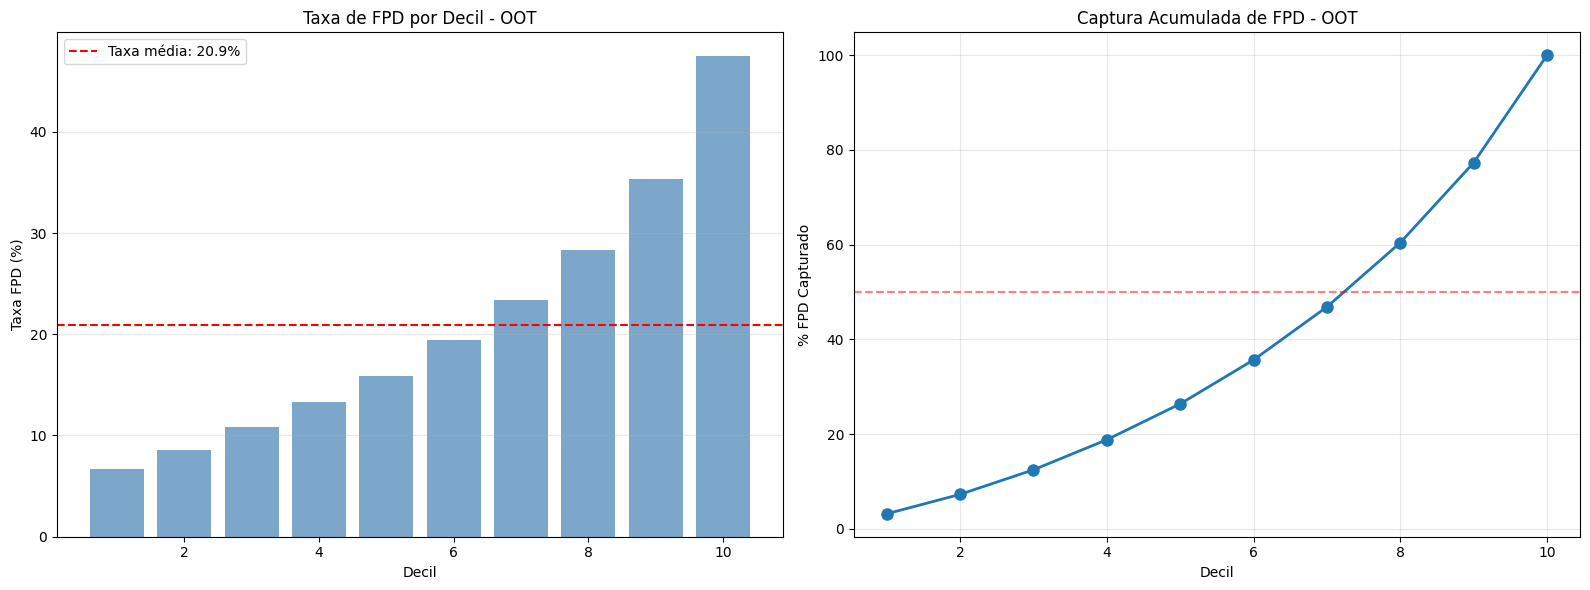

30

In [ ]:
# ========================================
# 6. ANÁLISE DE DECIS
# ========================================

print(f"\n{'='*60}")
print("📊 ANÁLISE DE DECIS (10 FAIXAS)")
print("="*60)

def calcular_decis(y_true, y_pred_proba, n_bins=10):
    """Calcula tabela de decis"""
    df_decis = pd.DataFrame({
        'target': y_true,
        'proba': y_pred_proba
    })

    # Criar decis
    df_decis['decil'] = pd.qcut(df_decis['proba'], q=n_bins, labels=False, duplicates='drop') + 1

    # Agregar
    decis = df_decis.groupby('decil').agg({
        'target': ['count', 'sum', 'mean'],
        'proba': ['min', 'max', 'mean']
    }).reset_index()

    decis.columns = ['decil', 'qtd', 'qtd_fpd', 'taxa_fpd', 'prob_min', 'prob_max', 'prob_media']

    # Acumulados
    decis['qtd_acum'] = decis['qtd'].cumsum()
    decis['qtd_fpd_acum'] = decis['qtd_fpd'].cumsum()
    decis['pct_fpd_acum'] = decis['qtd_fpd_acum'] / decis['qtd_fpd'].sum() * 100

    return decis

decis_oot = calcular_decis(y_true, y_pred_proba)

print("\nDECIS - OOT:")
print(decis_oot[['decil', 'qtd', 'qtd_fpd', 'taxa_fpd', 'prob_min', 'prob_max', 'pct_fpd_acum']].to_string(index=False))

print(f"\n📊 Top 3 decis (OOT) capturam {decis_oot.head(3)['pct_fpd_acum'].iloc[-1]:.1f}% dos FPDs")
print(f"📊 Top 5 decis (OOT) capturam {decis_oot.head(5)['pct_fpd_acum'].iloc[-1]:.1f}% dos FPDs")

# ========================================
# 7. VISUALIZAÇÕES DOS DECIS
# ========================================

print(f"\n{'='*60}")
print("📊 GERANDO VISUALIZAÇÕES DOS DECIS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot de Taxa de FPD por Decil
axes[0].bar(decis_oot['decil'], decis_oot['taxa_fpd']*100, color='steelblue', alpha=0.7)
axes[0].axhline(y=y_true.mean()*100, color='r', linestyle='--', label=f'Taxa média: {y_true.mean()*100:.1f}%')
axes[0].set_xlabel('Decil')
axes[0].set_ylabel('Taxa FPD (%)')
axes[0].set_title('Taxa de FPD por Decil - OOT')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Plot de Captura Acumulada
axes[1].plot(decis_oot['decil'], decis_oot['pct_fpd_acum'], marker='o', linewidth=2, markersize=8)
axes[1].axhline(y=50, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Decil')
axes[1].set_ylabel('% FPD Capturado')
axes[1].set_title('Captura Acumulada de FPD - OOT')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

gc.collect()

📊 ANÁLISE COMPLETA OOT COM COMPARAÇÕES

1️⃣ Carregando predições OOT...
OOT: (820593, 4)
Safras: ['202502', '202503']
Taxa FPD real: 20.9173%

2️⃣ Carregando predições treino/val...
Train: (380764, 5)
Val: (130148, 5)

3️⃣ Calculando métricas...

📊 Métricas Comparativas:
         AUC      GINI     KS
Train:   0.7282   0.4564   0.3378
Val:     0.7194   0.4389   0.3255
OOT:     0.7067   0.4134   0.3077

⚠️ Degradação (Val → OOT):
   AUC: +0.0127 (✅ aceitável)
   KS:  +0.0177 (✅ aceitável)

4️⃣ CALCULANDO PSI (POPULATION STABILITY INDEX)

📊 PSI (Val → OOT): 0.2605
   ❌ MUDANÇA SIGNIFICATIVA - População OOT muito diferente! Investigar!

5️⃣ ANÁLISE DE DECIS

DECIS - OOT:
 decil   qtd  qtd_fpd  taxa_fpd  prob_min  prob_max  pct_fpd_acum
     1 82060     5484  0.066829  0.010933  0.089944      3.194948
     2 82060     7048  0.085888  0.089944  0.126461      7.301073
     3 82058     8898  0.108435  0.126462  0.167429     12.484998
     4 82059    10901  0.132843  0.167430  0.212500     18.8

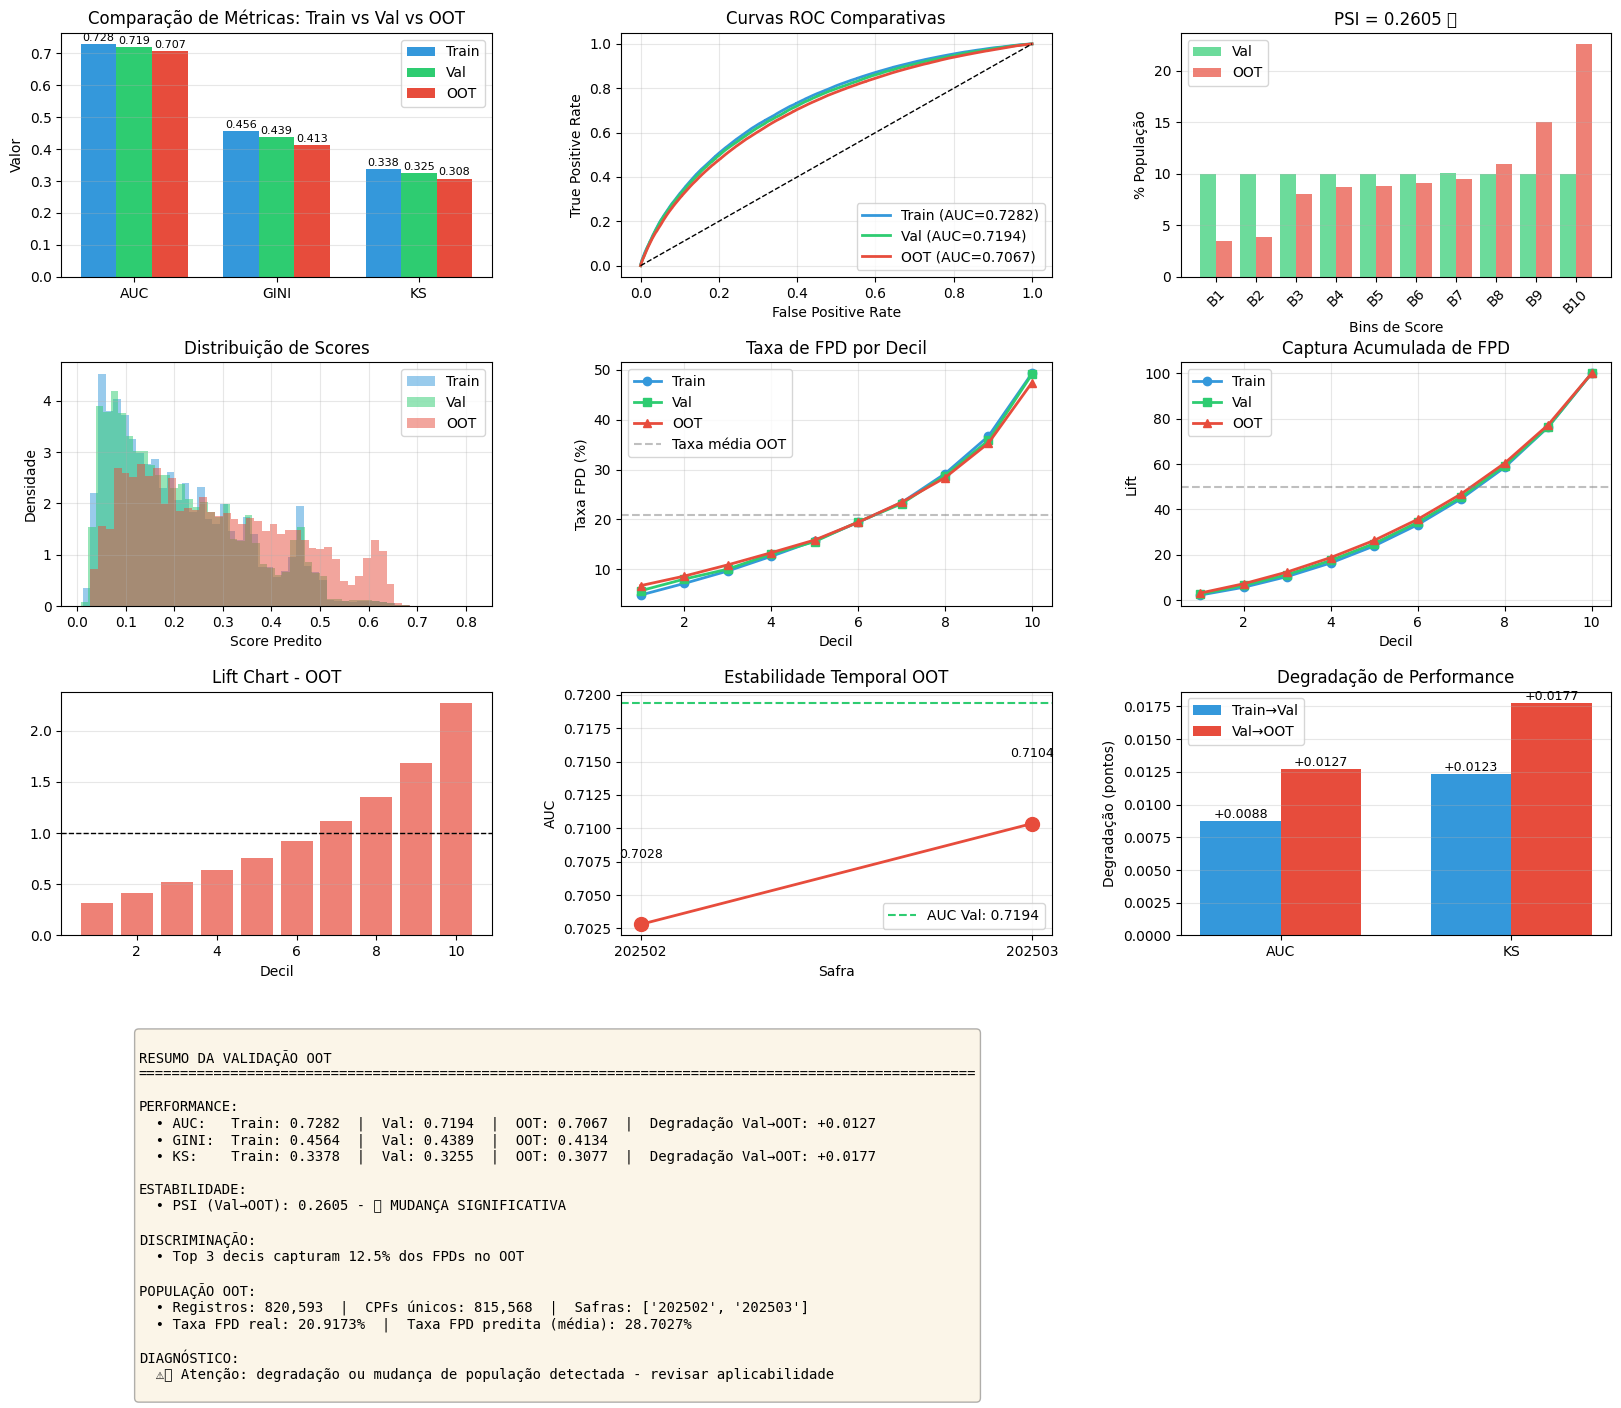


💾 SALVANDO RELATÓRIO OOT
✅ Relatório salvo: /content/drive/MyDrive/HACKA_2025/OOT/relatorio_validacao_oot.pkl
✅ Decis salvo: /content/drive/MyDrive/HACKA_2025/OOT/decis_oot.csv

🎉 ANÁLISE OOT COMPLETA CONCLUÍDA!


21

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc

# ========================================
# CONFIGURAÇÃO
# ========================================

MODEL_PATH = "/content/drive/MyDrive/HACKA_2025/models/06_baseline_final"
OOT_PATH = "/content/drive/MyDrive/HACKA_2025/OOT"

print("="*60)
print("📊 ANÁLISE COMPLETA OOT COM COMPARAÇÕES")
print("="*60)

# ========================================
# 1. CARREGAR PREDIÇÕES OOT
# ========================================

print("\n1️⃣ Carregando predições OOT...")

# Carrega os scores gerados
df_oot_scored = pd.read_parquet(f"{OOT_PATH}/datasets/oot_scored_final.parquet")
# Garante que NUM_CPF seja tratado como string e SAFRA seja normalizada para merge
df_oot_scored['NUM_CPF'] = df_oot_scored['NUM_CPF'].astype(str)
df_oot_scored['SAFRA'] = df_oot_scored['SAFRA'].astype(str).str.replace('.0', '', regex=False)

# Carrega a base original para obter o FPD
df_original_fpd = pd.read_parquet(f"{OOT_PATH}/df_OOT_base")[['NUM_CPF', 'SAFRA', 'FPD']]
# Garante que NUM_CPF seja tratado como string e SAFRA seja normalizada para merge
df_original_fpd['NUM_CPF'] = df_original_fpd['NUM_CPF'].astype(str)
df_original_fpd['SAFRA'] = df_original_fpd['SAFRA'].astype(str).str.replace('.0', '', regex=False)
# Converter FPD para int
df_original_fpd['FPD'] = df_original_fpd['FPD'].astype(int)

# Merge das duas bases para ter FPD e SCORE_MODEL no mesmo DataFrame
df_oot = pd.merge(df_oot_scored, df_original_fpd, on=['NUM_CPF', 'SAFRA'], how='inner')

print(f"OOT: {df_oot.shape}")
print(f"Safras: {sorted(df_oot['SAFRA'].unique())}")
print(f"Taxa FPD real: {df_oot['FPD'].mean():.4%}")

y_oot = df_oot['FPD']
y_oot_pred = df_oot['SCORE_MODEL']

# ========================================
# 2. CARREGAR PREDIÇÕES TREINO/VAL
# ========================================

print("\n2️⃣ Carregando predições treino/val...")

df_train_pred = pd.read_parquet(f"{MODEL_PATH}/predicoes_train_final.parquet")
df_val_pred = pd.read_parquet(f"{MODEL_PATH}/predicoes_val_final.parquet")

print(f"Train: {df_train_pred.shape}")
print(f"Val: {df_val_pred.shape}")

y_train = df_train_pred['FPD_real']
y_train_pred = df_train_pred['FPD_pred_proba']

y_val = df_val_pred['FPD_real']
y_val_pred = df_val_pred['FPD_pred_proba']

# ========================================
# 3. CALCULAR MÉTRICAS
# ========================================

print("\n3️⃣ Calculando métricas...")

def calcular_metricas(y_true, y_pred):
    """Calcula AUC, GINI, KS"""
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1

    # KS
    df_ks = pd.DataFrame({'target': y_true, 'proba': y_pred}).sort_values('proba', ascending=False)
    df_ks['good'] = 1 - df_ks['target']
    df_ks['bad'] = df_ks['target']
    df_ks['cum_good'] = df_ks['good'].cumsum() / df_ks['good'].sum()
    df_ks['cum_bad'] = df_ks['bad'].cumsum() / df_ks['bad'].sum()
    df_ks['ks'] = abs(df_ks['cum_good'] - df_ks['cum_bad'])
    ks = df_ks['ks'].max()

    return {'AUC': auc, 'GINI': gini, 'KS': ks}

metricas_train = calcular_metricas(y_train, y_train_pred)
metricas_val = calcular_metricas(y_val, y_val_pred)
metricas_oot = calcular_metricas(y_oot, y_oot_pred)

print("\n📊 Métricas Comparativas:")
print(f"         AUC      GINI     KS")
print(f"Train:   {metricas_train['AUC']:.4f}   {metricas_train['GINI']:.4f}   {metricas_train['KS']:.4f}")
print(f"Val:     {metricas_val['AUC']:.4f}   {metricas_val['GINI']:.4f}   {metricas_val['KS']:.4f}")
print(f"OOT:     {metricas_oot['AUC']:.4f}   {metricas_oot['GINI']:.4f}   {metricas_oot['KS']:.4f}")

# Degradação
deg_auc = metricas_val['AUC'] - metricas_oot['AUC']
deg_ks = metricas_val['KS'] - metricas_oot['KS']

print(f"\n⚠️ Degradação (Val → OOT):")
print(f"   AUC: {deg_auc:+.4f} ({'❌ significativa' if abs(deg_auc) > 0.05 else '✅ aceitável'})")
print(f"   KS:  {deg_ks:+.4f} ({'❌ significativa' if abs(deg_ks) > 0.05 else '✅ aceitável'})")

# ========================================
# 4. PSI (POPULATION STABILITY INDEX)
# ========================================

print(f"\n{'='*60}")
print("4️⃣ CALCULANDO PSI (POPULATION STABILITY INDEX)")
print("="*60)

def calcular_psi(base_scores, oot_scores, n_bins=10):
    """
    Calcula PSI entre duas distribuições de scores
    PSI < 0.1: estável
    0.1 <= PSI < 0.25: mudança moderada
    PSI >= 0.25: mudança significativa (investigar!)
    """
    # Criar bins baseados na base de desenvolvimento
    bins = pd.qcut(base_scores, q=n_bins, duplicates='drop', retbins=True)[1]
    bins[0] = -np.inf
    bins[-1] = np.inf

    # Distribuição base
    base_dist = pd.cut(base_scores, bins=bins).value_counts(normalize=True).sort_index()

    # Distribuição OOT
    oot_dist = pd.cut(oot_scores, bins=bins).value_counts(normalize=True).sort_index()

    # Alinhar índices
    base_dist, oot_dist = base_dist.align(oot_dist, fill_value=0.0001)

    # Evitar log(0)
    base_dist = base_dist.replace(0, 0.0001)
    oot_dist = oot_dist.replace(0, 0.0001)

    # Calcular PSI
    psi = ((oot_dist - base_dist) * np.log(oot_dist / base_dist)).sum()

    return psi, base_dist, oot_dist

psi_val_oot, dist_val, dist_oot = calcular_psi(y_val_pred, y_oot_pred)

print(f"\n📊 PSI (Val → OOT): {psi_val_oot:.4f}")
if psi_val_oot < 0.1:
    print(f"   ✅ ESTÁVEL - População OOT é similar ao desenvolvimento")
elif psi_val_oot < 0.25:
    print(f"   ⚠️ MUDANÇA MODERADA - Revisar características da população OOT")
else:
    print(f"   ❌ MUDANÇA SIGNIFICATIVA - População OOT muito diferente! Investigar!")

# ========================================
# 5. ANÁLISE DE DECIS
# ========================================

print(f"\n{'='*60}")
print("5️⃣ ANÁLISE DE DECIS")
print("="*60)

def calcular_decis(y_true, y_pred, n_bins=10):
    """Calcula tabela de decis"""
    df = pd.DataFrame({'target': y_true, 'proba': y_pred})
    df['decil'] = pd.qcut(df['proba'], q=n_bins, labels=False, duplicates='drop') + 1

    decis = df.groupby('decil').agg({
        'target': ['count', 'sum', 'mean'],
        'proba': ['min', 'max', 'mean']
    }).reset_index()

    decis.columns = ['decil', 'qtd', 'qtd_fpd', 'taxa_fpd', 'prob_min', 'prob_max', 'prob_media']
    decis['pct_fpd_acum'] = decis['qtd_fpd'].cumsum() / decis['qtd_fpd'].sum() * 100

    return decis

decis_train = calcular_decis(y_train, y_train_pred)
decis_val = calcular_decis(y_val, y_val_pred)
decis_oot = calcular_decis(y_oot, y_oot_pred)

print("\nDECIS - OOT:")
print(decis_oot[['decil', 'qtd', 'qtd_fpd', 'taxa_fpd', 'prob_min', 'prob_max', 'pct_fpd_acum']].to_string(index=False))

print(f"\n📊 Top 3 decis capturam:")
print(f"   Train: {decis_train.head(3)['pct_fpd_acum'].iloc[-1]:.1f}%")
print(f"   Val:   {decis_val.head(3)['pct_fpd_acum'].iloc[-1]:.1f}%")
print(f"   OOT:   {decis_oot.head(3)['pct_fpd_acum'].iloc[-1]:.1f}%")

# ========================================
# 6. VISUALIZAÇÕES COMPLETAS
# ========================================

print(f"\n{'='*60}")
print("📊 GERANDO VISUALIZAÇÕES COMPARATIVAS")
print("="*60)

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# ===== PLOT 1: BARRAS COMPARATIVAS MÉTRICAS =====
ax1 = fig.add_subplot(gs[0, 0])
metricas_df = pd.DataFrame({
    'Train': [metricas_train['AUC'], metricas_train['GINI'], metricas_train['KS']],
    'Val': [metricas_val['AUC'], metricas_val['GINI'], metricas_val['KS']],
    'OOT': [metricas_oot['AUC'], metricas_oot['GINI'], metricas_oot['KS']]
}, index=['AUC', 'GINI', 'KS'])

x = np.arange(len(metricas_df.index))
width = 0.25

ax1.bar(x - width, metricas_df['Train'], width, label='Train', color='#3498db')
ax1.bar(x, metricas_df['Val'], width, label='Val', color='#2ecc71')
ax1.bar(x + width, metricas_df['OOT'], width, label='OOT', color='#e74c3c')

ax1.set_ylabel('Valor')
ax1.set_title('Comparação de Métricas: Train vs Val vs OOT')
ax1.set_xticks(x)
ax1.set_xticklabels(metricas_df.index)
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# Adicionar valores nas barras
for i, metric in enumerate(metricas_df.index):
    ax1.text(i - width, metricas_df.loc[metric, 'Train'] + 0.01, f"{metricas_df.loc[metric, 'Train']:.3f}", ha='center', fontsize=8)
    ax1.text(i, metricas_df.loc[metric, 'Val'] + 0.01, f"{metricas_df.loc[metric, 'Val']:.3f}", ha='center', fontsize=8)
    ax1.text(i + width, metricas_df.loc[metric, 'OOT'] + 0.01, f"{metricas_df.loc[metric, 'OOT']:.3f}", ha='center', fontsize=8)

# ===== PLOT 2: CURVAS ROC COMPARATIVAS =====
ax2 = fig.add_subplot(gs[0, 1])

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
fpr_oot, tpr_oot, _ = roc_curve(y_oot, y_oot_pred)

ax2.plot(fpr_train, tpr_train, label=f'Train (AUC={metricas_train["AUC"]:.4f})', linewidth=2, color='#3498db')
ax2.plot(fpr_val, tpr_val, label=f'Val (AUC={metricas_val["AUC"]:.4f})', linewidth=2, color='#2ecc71')
ax2.plot(fpr_oot, tpr_oot, label=f'OOT (AUC={metricas_oot["AUC"]:.4f})', linewidth=2, color='#e74c3c')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Curvas ROC Comparativas')
ax2.legend()
ax2.grid(alpha=0.3)

# ===== PLOT 3: PSI VISUAL =====
ax3 = fig.add_subplot(gs[0, 2])

bins_labels = [f'B{i+1}' for i in range(len(dist_val))]
x_pos = np.arange(len(bins_labels))

ax3.bar(x_pos - 0.2, dist_val.values * 100, 0.4, label='Val', color='#2ecc71', alpha=0.7)
ax3.bar(x_pos + 0.2, dist_oot.values * 100, 0.4, label='OOT', color='#e74c3c', alpha=0.7)

ax3.set_xlabel('Bins de Score')
ax3.set_ylabel('% População')
ax3.set_title(f'PSI = {psi_val_oot:.4f} {"✅" if psi_val_oot < 0.1 else "⚠️" if psi_val_oot < 0.25 else "❌"}')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(bins_labels, rotation=45)
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# ===== PLOT 4: DISTRIBUIÇÃO DE SCORES =====
ax4 = fig.add_subplot(gs[1, 0])

ax4.hist(y_train_pred, bins=50, alpha=0.5, label='Train', density=True, color='#3498db')
ax4.hist(y_val_pred, bins=50, alpha=0.5, label='Val', density=True, color='#2ecc71')
ax4.hist(y_oot_pred, bins=50, alpha=0.5, label='OOT', density=True, color='#e74c3c')

ax4.set_xlabel('Score Predito')
ax4.set_ylabel('Densidade')
ax4.set_title('Distribuição de Scores')
ax4.legend()
ax4.grid(alpha=0.3)

# ===== PLOT 5: TAXA FPD POR DECIL =====
ax5 = fig.add_subplot(gs[1, 1])

ax5.plot(decis_train['decil'], decis_train['taxa_fpd']*100, marker='o', label='Train', linewidth=2, color='#3498db')
ax5.plot(decis_val['decil'], decis_val['taxa_fpd']*100, marker='s', label='Val', linewidth=2, color='#2ecc71')
ax5.plot(decis_oot['decil'], decis_oot['taxa_fpd']*100, marker='^', label='OOT', linewidth=2, color='#e74c3c')

ax5.axhline(y=y_oot.mean()*100, color='gray', linestyle='--', alpha=0.5, label='Taxa média OOT')

ax5.set_xlabel('Decil')
ax5.set_ylabel('Taxa FPD (%)')
ax5.set_title('Taxa de FPD por Decil')
ax5.legend()
ax5.grid(alpha=0.3)

# ===== PLOT 6: CAPTURA ACUMULADA =====
ax6 = fig.add_subplot(gs[1, 2])

ax6.plot(decis_train['decil'], decis_train['pct_fpd_acum'], marker='o', label='Train', linewidth=2, color='#3498db')
ax6.plot(decis_val['decil'], decis_val['pct_fpd_acum'], marker='s', label='Val', linewidth=2, color='#2ecc71')
ax6.plot(decis_oot['decil'], decis_oot['pct_fpd_acum'], marker='^', label='OOT', linewidth=2, color='#e74c3c')

ax6.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax6.set_xlabel('Decil')
ax6.set_ylabel('% FPD Capturado')
ax6.set_title('Captura Acumulada de FPD')
ax6.legend()
ax6.grid(alpha=0.3)

# ===== PLOT 7: LIFT CHART =====
ax7 = fig.add_subplot(gs[2, 0])

taxa_media_oot = y_oot.mean()
lift_oot = (decis_oot['taxa_fpd'] / taxa_media_oot)

ax7.bar(decis_oot['decil'], lift_oot, color='#e74c3c', alpha=0.7)
ax7.axhline(y=1, color='black', linestyle='--', linewidth=1)
ax7.set_xlabel('Decil')
ax6.set_ylabel('Lift')
ax7.set_title('Lift Chart - OOT')
ax7.grid(alpha=0.3, axis='y')

# ===== PLOT 8: ESTABILIDADE TEMPORAL (SE OOT TEM MÚLTIPLAS SAFRAS) =====
ax8 = fig.add_subplot(gs[2, 1])

if df_oot['SAFRA'].nunique() > 1:
    estab_temporal = df_oot.groupby('SAFRA').apply(
        lambda x: roc_auc_score(x['FPD'], x['SCORE_MODEL'])
    ).reset_index()
    estab_temporal.columns = ['SAFRA', 'AUC']

    ax8.plot(estab_temporal['SAFRA'], estab_temporal['AUC'], marker='o', linewidth=2, markersize=10, color='#e74c3c')
    ax8.axhline(y=metricas_val['AUC'], color='#2ecc71', linestyle='--', label=f'AUC Val: {metricas_val["AUC"]:.4f}')
    ax8.set_xlabel('Safra')
    ax8.set_ylabel('AUC')
    ax8.set_title('Estabilidade Temporal OOT')
    ax8.legend()
    ax8.grid(alpha=0.3)

    for i, row in estab_temporal.iterrows():
        ax8.text(i, row['AUC'] + 0.005, f"{row['AUC']:.4f}", ha='center', fontsize=9)
else:
    ax8.text(0.5, 0.5, 'OOT tem apenas 1 safra', ha='center', va='center', transform=ax8.transAxes, fontsize=12)
    ax8.set_title('Estabilidade Temporal OOT')

# ===== PLOT 9: DEGRADAÇÃO VISUAL =====
ax9 = fig.add_subplot(gs[2, 2])

degradacao_df = pd.DataFrame({
    'Métrica': ['AUC', 'KS'],
    'Train→Val': [metricas_train['AUC'] - metricas_val['AUC'], metricas_train['KS'] - metricas_val['KS']],
    'Val→OOT': [metricas_val['AUC'] - metricas_oot['AUC'], metricas_val['KS'] - metricas_oot['KS']]
})

x_pos = np.arange(len(degradacao_df))
width = 0.35

bars1 = ax9.bar(x_pos - width/2, degradacao_df['Train→Val'], width, label='Train→Val', color='#3498db')
bars2 = ax9.bar(x_pos + width/2, degradacao_df['Val→OOT'], width, label='Val→OOT', color='#e74c3c')

ax9.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax9.set_ylabel('Degradação (pontos)')
ax9.set_title('Degradação de Performance')
ax9.set_xticks(x_pos)
ax9.set_xticklabels(degradacao_df['Métrica'])
ax9.legend()
ax9.grid(alpha=0.3, axis='y')

# Adicionar valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.4f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# ===== PLOT 10: TABELA RESUMO =====
ax10 = fig.add_subplot(gs[3, :])
ax10.axis('off')

resumo_text = f"""
RESUMO DA VALIDAÇÃO OOT
{'='*100}

PERFORMANCE:
  • AUC:   Train: {metricas_train['AUC']:.4f}  |  Val: {metricas_val['AUC']:.4f}  |  OOT: {metricas_oot['AUC']:.4f}  |  Degradação Val→OOT: {deg_auc:+.4f}
  • GINI:  Train: {metricas_train['GINI']:.4f}  |  Val: {metricas_val['GINI']:.4f}  |  OOT: {metricas_oot['GINI']:.4f}
  • KS:    Train: {metricas_train['KS']:.4f}  |  Val: {metricas_val['KS']:.4f}  |  OOT: {metricas_oot['KS']:.4f}  |  Degradação Val→OOT: {deg_ks:+.4f}

ESTABILIDADE:
  • PSI (Val→OOT): {psi_val_oot:.4f} - {'✅ ESTÁVEL' if psi_val_oot < 0.1 else '⚠️ MUDANÇA MODERADA' if psi_val_oot < 0.25 else '❌ MUDANÇA SIGNIFICATIVA'}

DISCRIMINAÇÃO:
  • Top 3 decis capturam {decis_oot.head(3)['pct_fpd_acum'].iloc[-1]:.1f}% dos FPDs no OOT

POPULAÇÃO OOT:
  • Registros: {len(df_oot):,}  |  CPFs únicos: {df_oot['NUM_CPF'].nunique():,}  |  Safras: {sorted(df_oot['SAFRA'].unique())}
  • Taxa FPD real: {y_oot.mean():.4%}  |  Taxa FPD predita (média): {y_oot_pred.mean():.4%}

DIAGNÓSTICO:
  {'✅ Modelo mantém boa performance no OOT - validação bem-sucedida!' if abs(deg_auc) < 0.05 and psi_val_oot < 0.25 else '⚠️ Atenção: degradação ou mudança de população detectada - revisar aplicabilidade'}
"""

ax10.text(0.05, 0.95, resumo_text, transform=ax10.transAxes, fontsize=10,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Salvar
plt.savefig(f"{OOT_PATH}/analise_completa_oot.png", dpi=300, bbox_inches='tight')
print(f"\n✅ Visualização salva: {OOT_PATH}/analise_completa_oot.png")
plt.show()

# ========================================
# 7. SALVAR RELATÓRIO COMPLETO
# ========================================

print(f"\n{'='*60}")
print("💾 SALVANDO RELATÓRIO OOT")
print("="*60)

relatorio_oot = {
    'metricas_train': metricas_train,
    'metricas_val': metricas_val,
    'metricas_oot': metricas_oot,
    'degradacao_auc': float(deg_auc),
    'degradacao_ks': float(deg_ks),
    'psi': float(psi_val_oot),
    'decis_oot': decis_oot.to_dict(),
    'n_registros': len(df_oot),
    'n_cpfs': df_oot['NUM_CPF'].nunique(),
    'safras': sorted(df_oot['SAFRA'].unique()),
    'taxa_fpd_real': float(y_oot.mean()),
    'taxa_fpd_pred': float(y_oot_pred.mean())
}

with open(f"{OOT_PATH}/relatorio_validacao_oot.pkl", 'wb') as f:
    pickle.dump(relatorio_oot, f)

# Salvar CSV de decis
decis_oot.to_csv(f"{OOT_PATH}/decis_oot.csv", index=False)

print(f"✅ Relatório salvo: {OOT_PATH}/relatorio_validacao_oot.pkl")
print(f"✅ Decis salvo: {OOT_PATH}/decis_oot.csv")

print(f"\n{'='*60}")
print("🎉 ANÁLISE OOT COMPLETA CONCLUÍDA!")
print("="*60)

gc.collect()
